# Image Analysis: Grain Size Measurement

:::{admonition} Learning Objectives   
After completing this lesson, you should be able to:
* install opencv-contrib-python for image analysis
* perform various image analysis techniques to analyze grain sizes such as
    * converting color to grayscale
    * Pyramid Mean Shift Filtering  
    * Gaussian Blur
    * thresholding
    * watershedding

:::

## Install opencv

First make sure you have cv2 installed.  Go to the anaconda power shell and run the following command: `pip install opencv-contrib-python` 

## Load Packages

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage
from skimage import io, color, measure
import pandas as pd

from PIL import Image
from IPython.display import display

from pathlib import Path

## Read Image File 

Let's take a look at what is actually stored in an image file.  We need this to better understand the steps below.  We will look at two types of images.  One is an RGB color image and the other is a grayscale image. Notice again that for images the origin is located at the top-left.  

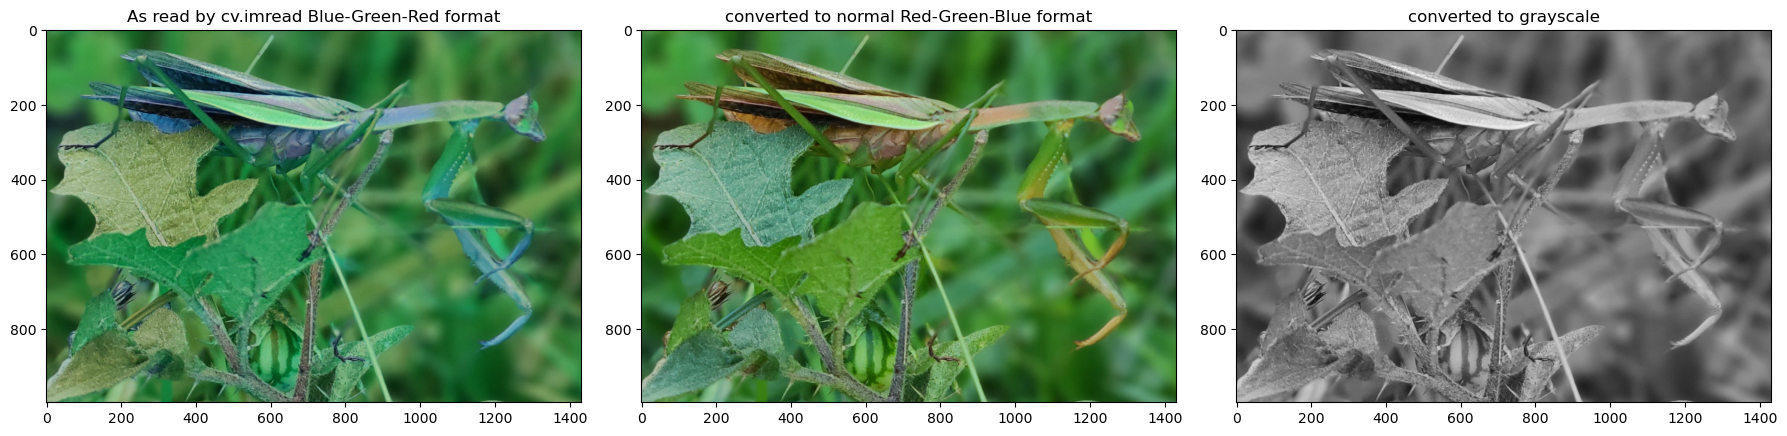

In [2]:
# cvread assumes the color image is in Blue-Green-Red format
img_cvread=cv.imread('../images/praying mantis small.jpg')
# convert read image to the correct Red-Green-Blue format
img_rgb=cv.cvtColor(img_cvread,cv.COLOR_BGR2RGB)
# convert to grayscale
img_gray=cv.cvtColor(img_rgb,cv.COLOR_RGB2GRAY) #move img to gray scale

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3,figsize=(18, 10))
ax1.imshow(img_cvread)
ax2.imshow(img_rgb)
ax3.imshow(img_gray, cmap='gray')
ax1.set_title('As read by cv.imread Blue-Green-Red format')
ax2.set_title('converted to normal Red-Green-Blue format')
ax3.set_title('converted to grayscale')
plt.tight_layout()

Let's look at the image file. The file is an array of [Red, Green, Blue] values.  Each value is from 0 to 255.  Each triple R-G-B represent one pixel on the image.  These are then arranged in rows and columns.  We can use .shape() to see the number of pixels in the rows and columns.  

In [3]:
display(img_rgb[0,0:4]) # row 0, points 0 to 3
img_rgb.shape

array([[ 75, 133,  57],
       [ 76, 134,  58],
       [ 78, 136,  60],
       [ 80, 138,  62]], dtype=uint8)

(996, 1430, 3)

So we have 996 rows each with 1430 values which consist of the triple [Red, Green, Blue] 

For grayscale images, each pixel only consists of one value between 0 and 255 where 0 is black and 255 would be white.  Let's take a look. 

In [4]:
print(img_gray.shape) # rows, columns, (depth=1) so it isn't given here
print(img_gray[0])  # look at row 0, points 0 through 3

(996, 1430)
[107 108 110 ...  77  77  76]


## Read a micrograph image and apply smoothing filters  

1. Pyramid Mean Shift Filtering  
2. Gaussian Blur

***We want to remove background noise in our original image, flatten out the image color, and provide some smoothing.***  

:::{admonition} Pyramid Mean Shift Filtering pyrMeanShiftFiltering()  
From the OpenCV documentation, "... the output of the function is the filtered "posterized" image with color gradients and fine-grain texture flattened."
:::

In [5]:
#img = cv.imread("grains callister.png")
#img=img[8:270, 10:230]
img=cv.imread('../images/GrainSizeAnalysis.jpg')
# correct image to RGB format
img=cv.cvtColor(img,cv.COLOR_BGR2RGB)
# apply filtering
img_shift=cv.pyrMeanShiftFiltering(img, 21, 41)  #acts on original image
gray=cv.cvtColor(img_shift,cv.COLOR_BGR2GRAY) #move img to gray scale
# Blurs an image using a Gaussian filter rather than a simple averaging of neighbor pixels
blur=cv.GaussianBlur(gray,(3,3),0) # acts on gray scale image

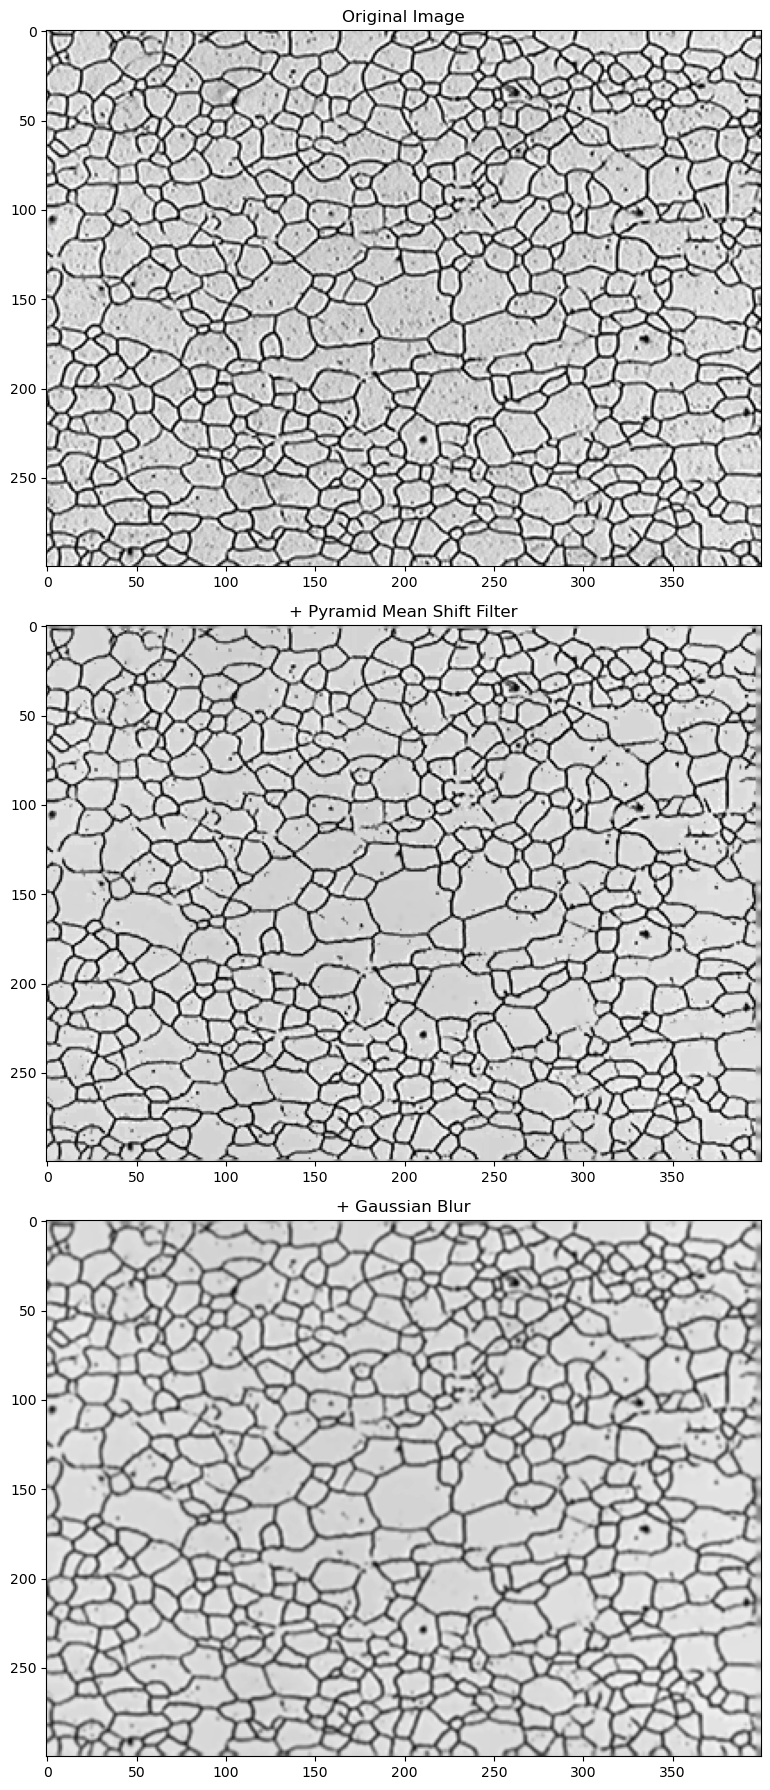

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1,figsize=(8, 18))
ax1.imshow(img)
ax2.imshow(gray, cmap='gray')
ax3.imshow(blur, cmap='gray')
ax1.set_title('Original Image')
ax2.set_title('+ Pyramid Mean Shift Filter')
ax3.set_title('+ Gaussian Blur')
plt.tight_layout()

:::{important}  
You should play around with the different parameters in the filters to see the effects especially in the thresholding below.  The parameters here may not work for other images.  In the case of grains, you are trying to make the grain boundaries stand out while reducing noise within the grains.  You also don't need to use all filters or any filters if the original image is good.  
:::

## Threshold the image to black (0) & white (255) 

You can read more about thresholding with examples here: https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html 

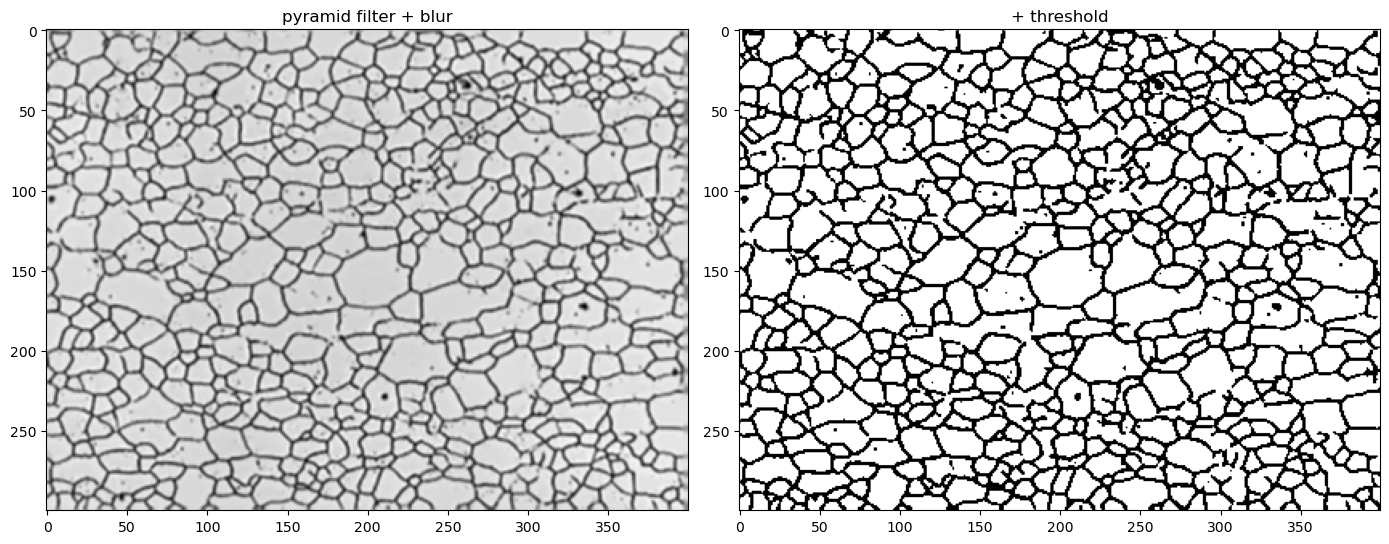

In [7]:
# change "blur" here to "gray" to see the effect of not including the gaussian blur
image_to_threshold=blur
#image_to_threshold=gray

#************** 3 choices here for performing threshold *********************
# try the different options below to see how they affect the image
ret, thresh = cv.threshold(image_to_threshold,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
#thresh= cv.adaptiveThreshold(image_to_threshold, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY, 7, 11)
#thresh = cv.adaptiveThreshold(image_to_threshold,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY,7,6)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(14, 7))
ax1.imshow(blur, cmap='gray')
ax2.imshow(thresh, cmap='gray')
ax1.set_title('pyramid filter + blur')
ax2.set_title('+ threshold')

plt.tight_layout()

After thresholding, our image only consists of either white (0) or black (255) pixels.  Below shows a small region of the above image and the corresponding data values.  

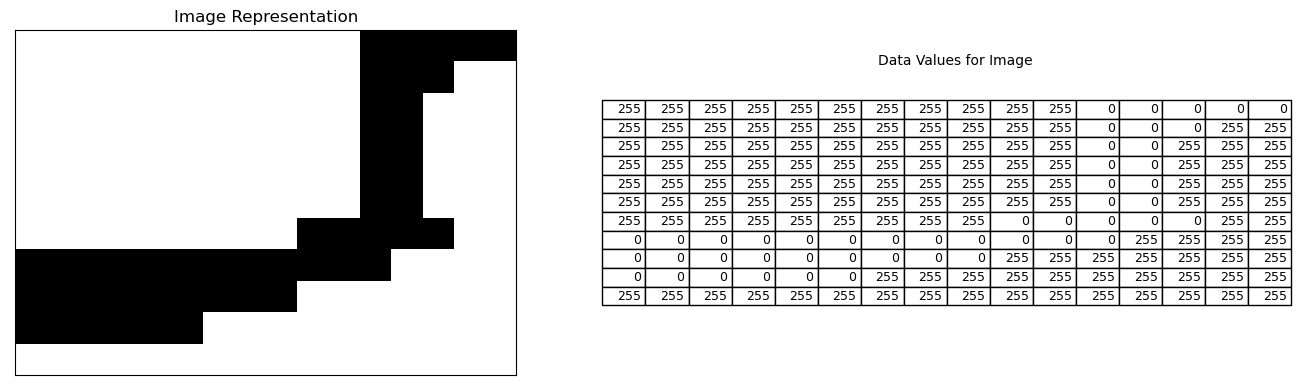

In [8]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(14, 4))
# let's take a look at a small pixel region rows:90 to 100, columns: 0 to 15
ax1.imshow(thresh[90:101, 0:16], cmap="gray");


df = pd.DataFrame(thresh).iloc[90:101, 0:16]
ax2.table(cellText=df.values, colLabels=None, loc='center')

ax2.axis('off')
#ax1.axis('off')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Image Representation')
ax2.text(0.4,0.9, 'Data Values for Image')

fig.tight_layout()
plt.show()

## Prepare for performing a watershed routine.  

When applying a filter, we can define the strength, size, and direction of the neighboring pixels that are used in the filter.  This is referred to as the kernel.  Examples can be found here: https://github.com/atduskgreg/opencv-processing-book/blob/master/book/filters/blur.md Three examples of kernels that are easily definable in OpenCV are shown below.  For a 3x3 kernel, the cross and ellipse are the same.  Change the values to 5x5 below to see the difference between the cross and ellipse.   

In [9]:
a=cv.getStructuringElement(cv.MORPH_CROSS,(3,3))
b=cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3))
c=cv.getStructuringElement(cv.MORPH_RECT,(3,3))
i=1
for item_a, item_b, item_c in zip(a, b,c):
    if i==1: 
        print(' CROSS',' ELLIPSE','  RECT')
        i=0
    print(item_a, item_b, item_c)

 CROSS  ELLIPSE   RECT
[0 1 0] [0 1 0] [1 1 1]
[1 1 1] [1 1 1] [1 1 1]
[0 1 0] [0 1 0] [1 1 1]


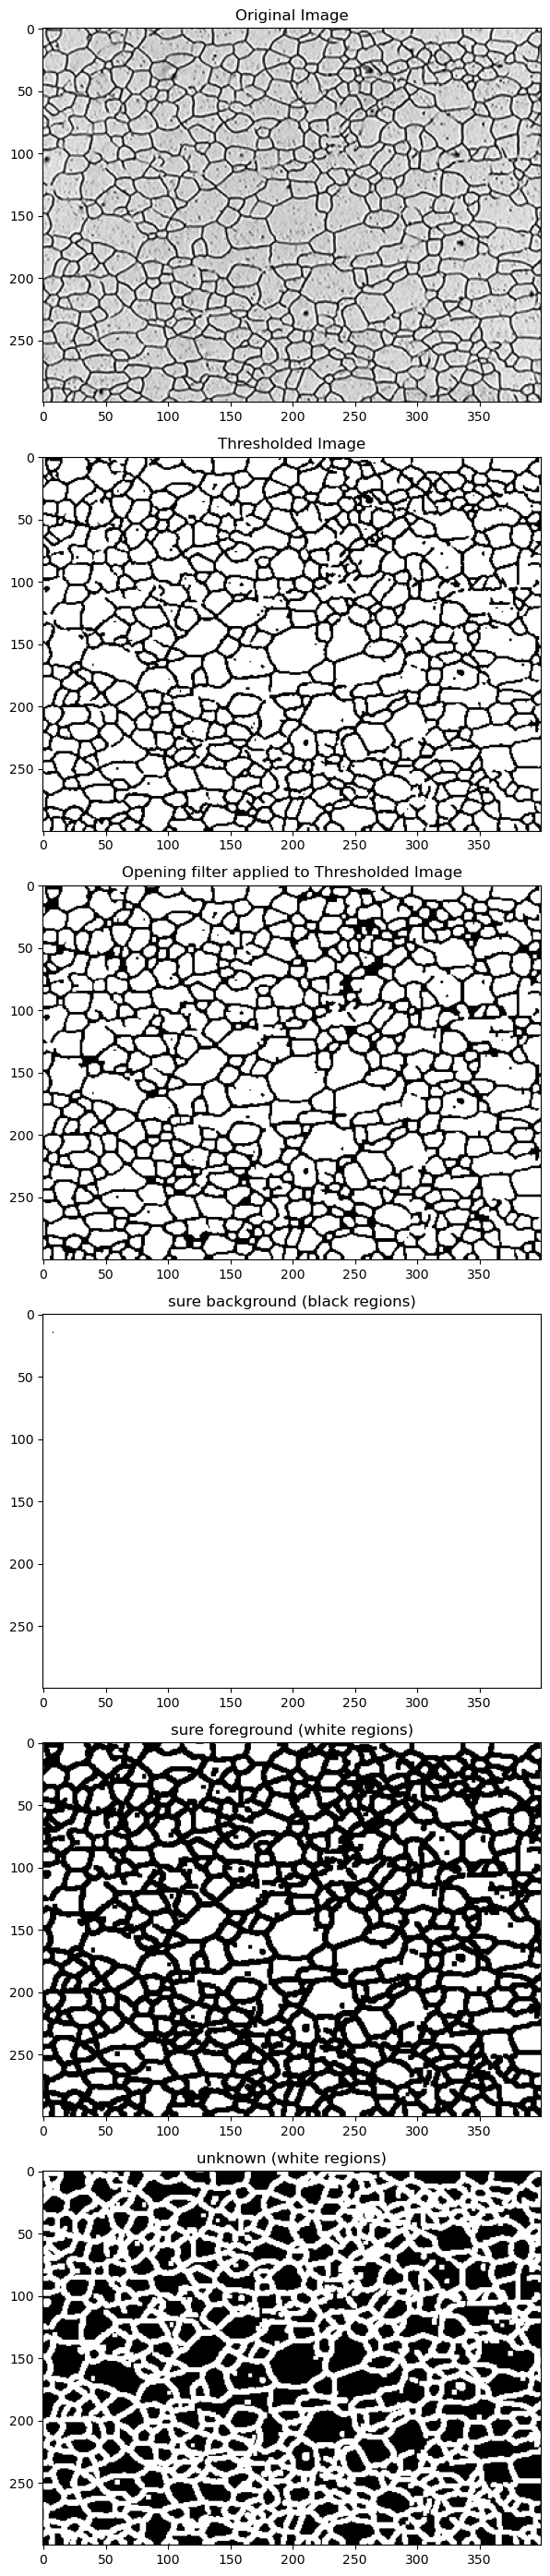

In [48]:
kernel=cv.getStructuringElement(cv.MORPH_CROSS,(3,3))
# kernel=cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3))
kernel=cv.getStructuringElement(cv.MORPH_RECT,(3,3))

# noise removal
opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations=1)

# finding areas on image that we are confident are background (black) and foreground (white)

# sure background area -- white areas (grains) expand outward
sure_bg = cv.dilate(opening,kernel,iterations=4)

# Finding sure foreground area -- white regions contract inward
sure_fg = cv.erode(opening,kernel,iterations=1)

# The unknown region is the background - foreground
# Finding unknown region 
unknown = cv.subtract(sure_bg,sure_fg)


# ******************* Display results of each step ********************

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=6, ncols=1,figsize=(8, 28))
ax1.imshow(img, cmap='gray')
ax2.imshow(thresh, cmap='gray')
ax3.imshow(opening, cmap='gray')
ax4.imshow(sure_bg, cmap='gray')
ax5.imshow(sure_fg, cmap='gray')
ax6.imshow(unknown, cmap='gray')

ax1.set_title('Original Image')
ax2.set_title('Thresholded Image')
ax3.set_title('Opening filter applied to Thresholded Image')
ax4.set_title('sure background (black regions)')
ax5.set_title('sure foreground (white regions)')
ax6.set_title('unknown (white regions)')
plt.tight_layout()

### Label known foreground regions

Each contiguous white area in the known foreground image is assigned a number, the black regions are assigned 0.  

In [61]:
# Marker labelling
# cv2.connectedComponents(). labels background of the image with -1, 
# then other objects are labelled with integers starting from 1.
ret, markers = cv.connectedComponents(sure_fg)

Let's plot a region of the image data in 'markers' and see how the known regions are numbered and everything between these is labeled 0.    

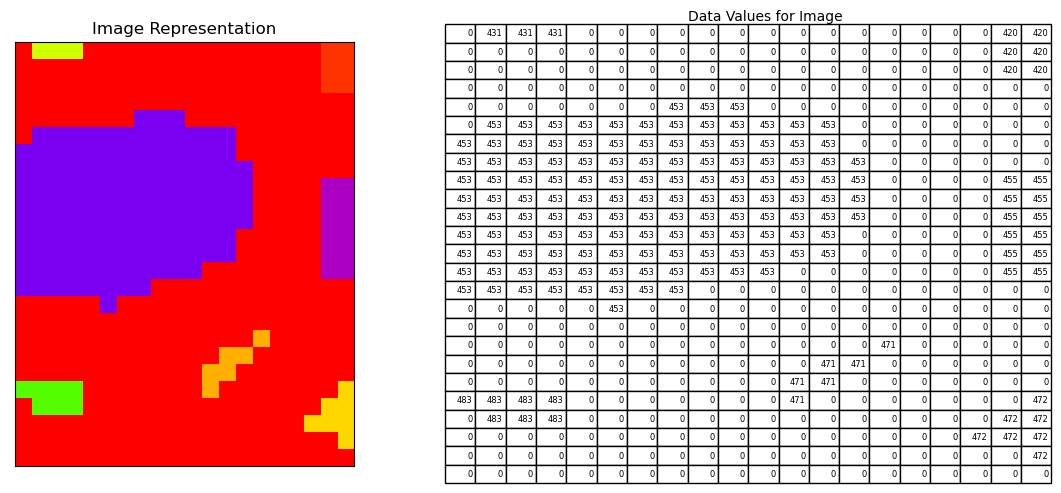

In [62]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(12, 5))
# let's take a look at a small pixel region rows:90 to 100, columns: 0 to 15
ax1.imshow(pd.DataFrame(markers).iloc[250:275, 200:220], cmap='prism');


df = pd.DataFrame(markers).iloc[250:275, 200:220]
ax2.table(cellText=df.values, colLabels=None, loc='center')

ax2.axis('off')
#ax1.axis('off')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Image Representation')
ax2.text(0.4,1.05, 'Data Values for Image')

fig.tight_layout()
plt.show()

### Keep our markers but change the "unknown" regions from -1 to 0

The watershed routine will start in each numbered area (in the original filtered & blurred image) and fill these areas with the appropriate colored "water" using the grayscale values as heights. The filling continues until the colored water between grains begins to touch.  This then defines the interface or grain boundary in our case.  The boundary is then set to a value of -1 by the watershed function and we then color these red in the original image.  

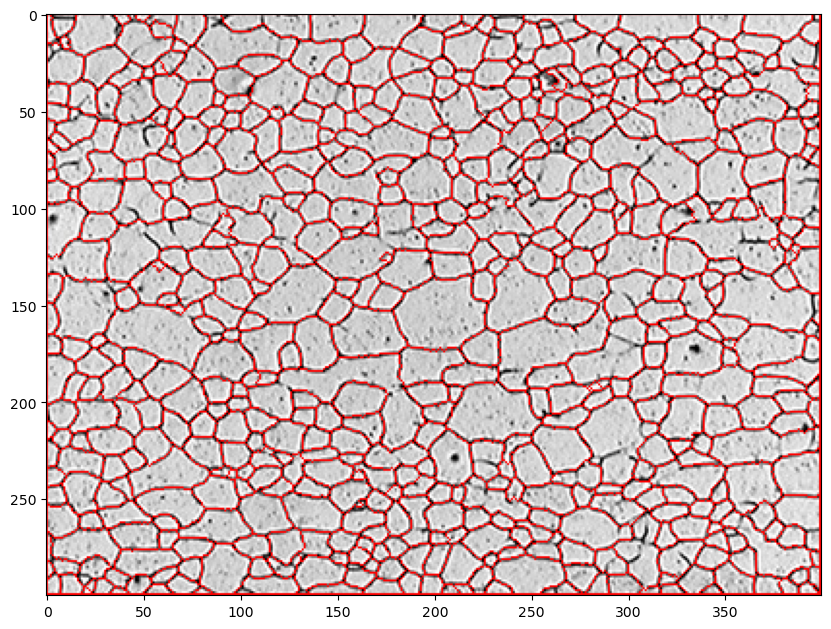

In [67]:
# Add one to all labels so that our minimum value is now 1 rather than zero
markers = markers+1

# Now, using the image "unknown" as a mask we take all pixel positions in this image
# marked as unknown (white = 255) and label these as zero in the image "markers". 
markers[unknown==255] = 0

# boundaries are labeled -1 now by cv.watershed
markers = cv.watershed(img,markers)  # img needs shape (pix, pix, 3), markers is (pix, pix)
img_red=img.copy()
# change boundaries (-1) regions to red i.e. RGB=(255,0,0)
img_red[markers ==-1] = [255,0,0]

#display(Image.fromarray(markers))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111) # 1x1 grid, first subplot

ax.imshow(img_red)

plt.show()


### Change the marker labels to colors and combine with the original image

Example of named colors that can be used. 

:::{image} ../images/12_named_colors.png
:width: 600px
:align: center
:::

<img alt="" src="../images/12_named_colors.png" width=600px>

In [117]:
import matplotlib.colors as mcolors
# # uncomment to see all available colors
# import matplotlib.colors as mcolors
# [[i,list(mcolors.CSS4_COLORS.keys())[i]] for i in np.arange(148)]
# The above code will show you what colors each of the numbers below corresponds to.
# I'm picking my favorites.  
colorlist=[2,121,27,68,103,45,146,120,147,98,65,16,109,125,82,113,3,30,76,6,138,52,20,51,67,136,95,44,40,80,111,122,115,9,131,90,10,139,116,118,22]
colors=[list(mcolors.CSS4_COLORS.keys())[i] for i in colorlist]

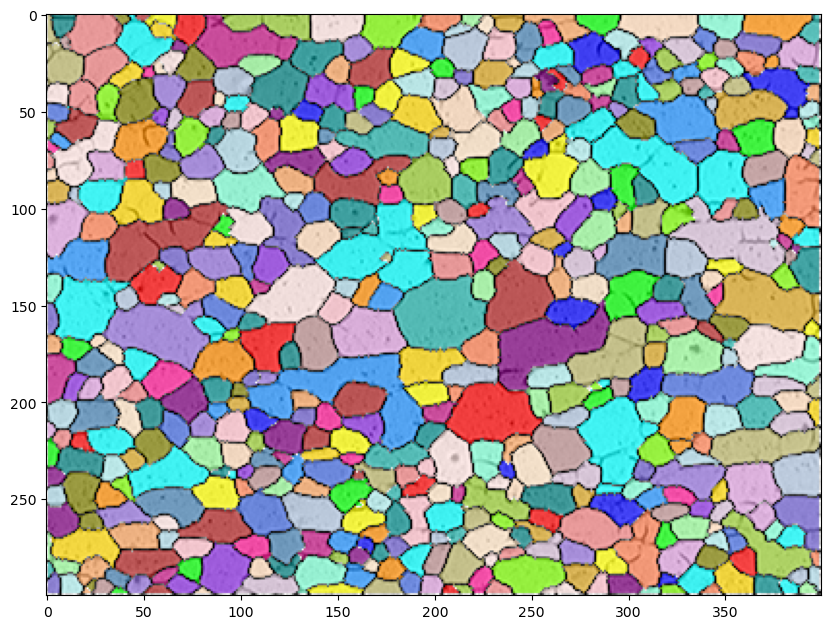

In [118]:
img2=color.label2rgb(markers, image=img, bg_label=-1, alpha=0.7, bg_color=None, colors=colors)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111) # 1x1 grid, first subplot
ax.imshow(img2);
plt.show()

#### Each colored grain can now be analyzed and placed in a Pandas DataFrame

In [119]:
# values in table below are in pixel units

propList=['label','area','equivalent_diameter','orientation','major_axis_length', 'minor_axis_length','perimeter']
#propList=['equivalent_diameter','orientation','area','major_axis_length']
props=measure.regionprops_table(markers, properties=propList)

grain_data=pd.DataFrame(props)

grain_data.head()

label  area  equivalent_diameter  orientation  major_axis_length  \
0      1    17             4.652426     0.302197           6.122026   
1      2    41             7.225152     0.231599          16.406235   
2      3   421            23.152405    -1.211855          28.644618   
3      4    23             5.411516     1.337246           6.658010   
4      5    13             4.068429    -1.535888           5.953264   

   minor_axis_length  perimeter  
0           3.622550  12.863961  
1           4.786356  32.278175  
2          19.212631  83.597980  
3           4.562920  16.278175  
4           2.880677  11.035534

Recall the grain size number from Callister was defined as $n=2^{G-1}$ where $n$ is the number of grains in a $1\ in^2$ area at 100x and $G$ is the grain size number.  This equation could be rewritten for, $n^*$, the number of grains per $mm^2$ at no magnification.  This would be $G = 3.322 Log(n^*)-2.9543$

In [120]:
# from the original image I used the micron bar to find the scaling factor microns per pixel
μm_per_pixel=0.9  # μm per pixel

avg_grain_diam=(grain_data.loc[:,'equivalent_diameter'].mean()*μm_per_pixel)
print(f'Avg. Grain Diameter = {avg_grain_diam:0.2f} μm')

max_grain_diam=(grain_data.loc[:,'equivalent_diameter'].max()*μm_per_pixel)
print(f'Max Grain Diameter = {max_grain_diam:0.2f} μm')

min_grain_diam=(grain_data.loc[:,'equivalent_diameter'].min()*μm_per_pixel)
print(f'Min Grain Diameter = {min_grain_diam:0.2f} μm\n')

avg_grain_area= grain_data.loc[:,'area'].mean()*μm_per_pixel**2 #μm^2
print(f'Avg. Grain Area = {avg_grain_area:0.2f} μm^2')

max_grain_area= grain_data.loc[:,'area'].max()*μm_per_pixel**2 #μm^2
print(f'Max Grain Area = {max_grain_area:0.2f} μm^2')

min_grain_area= grain_data.loc[:,'area'].min()*μm_per_pixel**2 #μm^2
print(f'Min Grain Area = {min_grain_area:0.2f} μm^2\n')

n= (avg_grain_area*10**-6)**-1 # grains per mm^2
print(f'Number of grains per mm^2 = {n:0.2f}')

# Grain Size number 
print(f'Grain Size number = {3.322*np.log10(n)-2.9543:0.2f}')

Avg. Grain Diameter = 12.68 μm
Max Grain Diameter = 41.16 μm
Min Grain Diameter = 1.02 μm

Avg. Grain Area = 156.30 μm^2
Max Grain Area = 1330.83 μm^2
Min Grain Area = 0.81 μm^2

Number of grains per mm^2 = 6397.93
Grain Size number = 9.69


## Exercises

### Problem 1

**(a)**  Pick one of the following images and find the grain size number.

:::{image} ../images/grain_image_25um_bar.png
:width: 600px
:align: center
:::


<img alt="" src="../images/grain_image_25um_bar.png" width=600px>

The above image can be used to get the number of pixels that equals 25 microns (black bar at bottom right).  The image below is to analyze. I removed the micron bar so it didn't affect the watershed.  

:::{image} ../images/grain_image_wo_25um_bar.png
:width: 600px
:align: center
:::

<img alt="" src="../images/grain_image_wo_25um_bar.png" width=600px>

The image below has enough grains that you can just crop the micron bar out of the image and analyze the remaining grains.

:::{image} ../images/grain_image_1.png
:width: 600px
:align: center
:::

<img alt="" src="../images/grain_image_1.png" width=600px>

:::{image} ../images/grains_callister.png
:width: 600px
:align: center
:::

<img alt="" src="../images/grains_callister.png" width=600px>

### Extra Credit / Challenge Problem

Determine the fraction of proeutectoid ferrite (white regions) in this image.  The remaining areas (darker colors) is pearlite.

:::{image} ../images/proeutectoid_alpha_and_pearlite.png
:width: 600px
:align: center
:::

<img alt="" src="../images/proeutectoid_alpha_and_pearlite.png" width=600px>